In [1]:
%matplotlib inline

In [20]:
import matplotlib.pyplot as plt

import xarray as xr
import numpy as np
import glob
import sys

from scipy.interpolate import interp2d

# Our modules
sys.path.append('/home/jovyan/segtrax/source')
from utilities import transform_coord


## Proof of concept for vectorized indexing in xarray
Create a DataArray

In [3]:
da = xr.DataArray(np.arange(12).reshape((3, 4)), dims=['x', 'y'], coords={'x': [0, 1, 2], 'y': ['a', 'b', 'c', 'd']})
da

<xarray.DataArray (x: 3, y: 4)>
array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11]])
Coordinates:
  * x        (x) int64 0 1 2
  * y        (y) <U1 'a' 'b' 'c' 'd'

Generate index DataArrays

In [4]:
ind_x = xr.DataArray([0, 1], dims=['i'])
ind_y = xr.DataArray([0, 2], dims=['i'])

Extract points

In [5]:
da[ind_x, ind_y]

<xarray.DataArray (i: 2)>
array([0, 6])
Coordinates:
    x        (i) int64 0 1
    y        (i) <U1 'a' 'c'
Dimensions without coordinates: i

## Try it with ice motion data

Read the ice motion data

In [6]:
motion_files = glob.glob('/home/jovyan/segtrax/data/icemotion*.nc')
ds = xr.open_mfdataset(motion_files, concat_dim='time', data_vars='different')
ds

<xarray.Dataset>
Dimensions:                 (time: 70, x: 361, y: 361)
Coordinates:
  * x                       (x) float64 -4.512e+06 -4.487e+06 ... 4.512e+06
  * y                       (y) float64 -4.512e+06 -4.487e+06 ... 4.512e+06
  * time                    (time) object 2019-01-01 00:00:00 ... 2018-12-24 12:00:00
Data variables:
    crs                     int32 -2147483647
    latitude                (y, x) float32 29.896942 30.080757 ... 29.896942
    longitude               (y, x) float32 -45.0 -44.8404 ... 135.15959 135.0
    u                       (time, y, x) float32 dask.array<shape=(70, 361, 361), chunksize=(18, 361, 361)>
    v                       (time, y, x) float32 dask.array<shape=(70, 361, 361), chunksize=(18, 361, 361)>
    number_of_observations  (time, y, x) float32 dask.array<shape=(70, 361, 361), chunksize=(18, 361, 361)>
Attributes:
    version:       QuickLook data based on Ice Motion version 4.1
    release_date:  May 2019
    Conventions:   CF-1.4
    

Plot one week of data

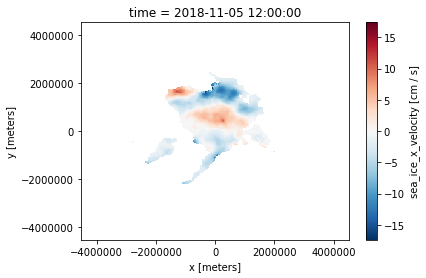

In [22]:
ds.sel(time='2018-11-05').u.plot()

Now we will generate some test points for interpolation.  These need to be in projected coordinates, so we use the `transform_coords` function to do this.

In [23]:
lat = [85.,86.,87.]
lon = [0.,5.,10.]
x, y = transform_coord(4326, 3408, lon, lat)
print (x, y)

[0.0, 38758.62082587721, 57921.845123659696] [-555818.1242497492, -443013.06322267157, -328491.107208524]


Plot as a sanity check and to make sure the points fall within the region with data.

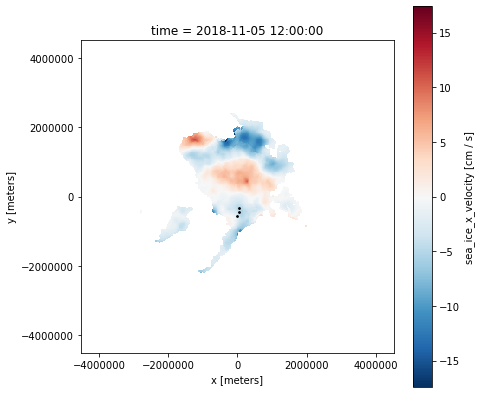

In [13]:
fig, ax = plt.subplots(figsize=(7,7))
ds.sel(time='2018-11-05').u.plot(ax=ax)
ax.scatter(x, y, c='k', s=3)
ax.set_aspect('equal')

Now we do a nearest neighbour interpolation to get the closest u and v to x and y.

To do this x and y need to be xarray DataArrays with the **same** dimensions.  The dimension name used for `ind_x` and `ind_y` does not have a dimension in the DataSet you are trying to subset.

In [14]:
ind_x = xr.DataArray(x, dims=['i'])
ind_y = xr.DataArray(y, dims=['i'])
print ( ds.sel(time='2018-11-05').latitude.sel(x=ind_x, y=ind_y, method='nearest').values )
print ( ds.sel(time='2018-11-05').longitude.sel(x=ind_x, y=ind_y, method='nearest').values )
print ( ds.sel(time='2018-11-05').u.sel(x=ind_x, y=ind_y, method='nearest').values )
print ( ds.sel(time='2018-11-05').v.sel(x=ind_x, y=ind_y, method='nearest').values )

[85.039    85.916435 87.03461 ]
[0.       6.340192 8.746162]
[[-2.  -4.4 -4.9]]
[[-6.1 -5.6 -4.2]]


## Interoplate ice motion vectors to arbitrary points

I use `scipy.interpolate.interp2d` for this.  This function returns 2d arrays.  So I use list comprehension to find individual x, y pairs.

In [16]:
u = ds.sel(time='2018-11-05').u.values
u[np.isnan(u)] = -99.9
v = ds.sel(time='2018-11-05').v.values
v[np.isnan(v)] = -99.9
fu = interp2d(ds.x, ds.y, u, kind='linear')
fv = interp2d(ds.x, ds.y, v, kind='linear')

In [17]:
print ('u = ', np.diag(fu(x, y)))
print ('v = ', np.diag(fv(x, y)))

u =  [-1.94814917 -4.22065543 -4.93430168]
v =  [-6.13456718 -5.56727877 -4.18583824]


Now write this as a nice function

In [18]:
def interp_uv(x, y, u, v, xi, yi):
    
    # Set NaN to -99.99 in u and v arrays
    # - probably not the best approach but it will work for now
    um = np.where(~np.isnan(u), u, -99.9)
    vm = np.where(~np.isnan(v), v, -99.9)
    
    fu = interp2d(x, y, um, kind='linear')
    fv = interp2d(x, y, vm, kind='linear')
    
    ui = np.array([fu(x_i, y_i) for x_i, y_i in zip(xi, yi)])
    vi = np.array([fv(x_i, y_i) for x_i, y_i in zip(xi, yi)])
    
    return ui.flatten(), vi.flatten()
    

...and we get the same results yea!

In [19]:
ui, vi = interp_uv(ds.x, ds.y, 
                   ds.sel(time='2018-11-05').u.values, 
                   ds.sel(time='2018-11-05').v.values, 
                   x, y)
print (ui)
print (vi)

[-1.94814917 -4.22065543 -4.93430168]
[-6.13456718 -5.56727877 -4.18583824]
